<a href="https://colab.research.google.com/github/binitgudhka28/IOSS-LAB-8/blob/main/mod%26sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Pre processing
def preprocess_data(df):
    # Encode categorical features
    label_encoders = {}
    for col in ['country', 'region']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature Engineering: Add Season Column
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:
            return 3  # Fall

    df['season'] = df['month'].apply(get_season)

    # Feature Engineering: Climate Risk Index
    df['climate_risk_index'] = (df['avg_temp_c'] * 0.3 + df['precipitation_mm'] * 0.2 +
                                 df['air_quality_index'] * 0.3 + df['uv_index'] * 0.2)

    # Standardization of numerical columns
    scaler = StandardScaler()
    num_cols = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index',
                'malaria_cases', 'dengue_cases', 'population_density', 'healthcare_budget',
                'climate_risk_index']
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df, label_encoders,scaler

In [ ]:
#Linear regression  model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data_path = '/content/processed_climate_disease_dataset.csv'
df = pd.read_csv(data_path)

# Display basic info and check for missing values
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Handle missing values (if any)
df = df.dropna()

# Create a new column for total cases
df['total_cases'] = df['malaria_cases'] + df['dengue_cases']

# Define the outbreak threshold as the mean + standard deviation
threshold = df['total_cases'].mean() + df['total_cases'].std()
df['outbreak'] = df['total_cases'].apply(lambda x: 1 if x >= threshold else 0)
print(f"Outbreak threshold: {threshold}")

# Selecting independent (climate factors) and dependent (cases) variables
X = df.drop(columns=['malaria_cases', 'dengue_cases', 'total_cases', 'outbreak'])
y = df['total_cases']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# What is the average number of total cases?
average_cases = df['total_cases'].mean()
print(f"Average cases: {average_cases}")

#How many cases fall below the average (non-outbreaks)?
non_outbreak_cases = df[df['outbreak'] == 0].shape[0]
print(f"Number of non-outbreak cases: {non_outbreak_cases}")

#How many cases fall above the average (outbreaks)?
outbreak_cases = df[df['outbreak'] == 1].shape[0]
print(f"Number of outbreak cases: {outbreak_cases}")

#What percentage of total cases are outbreaks?
outbreak_percentage = (outbreak_cases / df.shape[0]) * 100
print(f"Percentage of cases that are outbreaks: {outbreak_percentage:.2f}%")

#What are the climate factor averages for outbreak vs. non-outbreak cases?
climate_avg_outbreak = df[df['outbreak'] == 1].mean()
climate_avg_non_outbreak = df[df['outbreak'] == 0].mean()
print("Climate averages for outbreaks:")
print(climate_avg_outbreak)
print("Climate averages for non-outbreaks:")
print(climate_avg_non_outbreak)

#Does temperature, humidity, or rainfall differ significantly between outbreaks and non-outbreaks?
print("Temperature difference between outbreaks and non-outbreaks:")
print(df.groupby('outbreak')['avg_temp_c'].describe())
print("Precipitation difference between outbreaks and non-outbreaks:")
print(df.groupby('outbreak')['precipitation_mm'].describe())
print("Air quality difference between outbreaks and non-outbreaks:")
print(df.groupby('outbreak')['air_quality_index'].describe())

#Is there a strong correlation between total cases and climate conditions?
print("Correlation of climate factors with total cases:")
print(df.corr()['total_cases'].sort_values(ascending=False))

#Can we predict whether an outbreak will occur based on whether cases exceed the average?
outbreak_prediction_accuracy = (df['outbreak'] == (df['total_cases'] >= average_cases).astype(int)).mean() * 100
print(f"Accuracy of predicting outbreak occurrence based on average cases: {outbreak_prediction_accuracy:.2f}%")

#Do outbreaks cluster in specific months or seasons?
if 'month' in df.columns:
    monthly_outbreaks = df.groupby('month')['outbreak'].sum()
    print("Outbreak cases per month:")
    print(monthly_outbreaks)
if 'season' in df.columns:
    season_outbreaks = df.groupby('season')['outbreak'].sum()
    print("Outbreak cases per season:")
    print(season_outbreaks)

#Which climate factors show the most variation between outbreak and non-outbreak cases?
climate_variation = df.groupby('outbreak').std()
print("Climate factor variation between outbreak and non-outbreak cases:")
print(climate_variation)


#Identify climate factor thresholds for outbreaks
malaria_threshold = df['malaria_cases'].mean() + df['malaria_cases'].std()
dengue_threshold = df['dengue_cases'].mean() + df['dengue_cases'].std()
df['malaria_outbreak'] = df['malaria_cases'] >= malaria_threshold
df['dengue_outbreak'] = df['dengue_cases'] >= dengue_threshold

climate_columns = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index', 'population_density', 'healthcare_budget', 'climate_risk_index']

# Checking impact of climate conditions on outbreaks
print("Climate conditions for malaria outbreaks:")
print(df.groupby('malaria_outbreak')[climate_columns].mean())
print("Climate conditions for dengue outbreaks:")
print(df.groupby('dengue_outbreak')[climate_columns].mean())

# Predict number of malaria/dengue cases based on climate factors
X = df[climate_columns]
y_malaria = df['malaria_cases']
y_dengue = df['dengue_cases']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y_malaria, test_size=0.2, random_state=42)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_dengue, test_size=0.2, random_state=42)

malaria_model = LinearRegression()
dengue_model = LinearRegression()
malaria_model.fit(X_train_m, y_train_m)
dengue_model.fit(X_train_d, y_train_d)

# Predictions
y_pred_malaria = malaria_model.predict(X_test_m)
y_pred_dengue = dengue_model.predict(X_test_d)

# Model evaluation
mse_malaria = mean_squared_error(y_test_m, y_pred_malaria)
mse_dengue = mean_squared_error(y_test_d, y_pred_dengue)
r2_malaria = r2_score(y_test_m, y_pred_malaria)
r2_dengue = r2_score(y_test_d, y_pred_dengue)

print(f"Malaria - Mean Squared Error: {mse_malaria}, R² Score: {r2_malaria}")
print(f"Dengue - Mean Squared Error: {mse_dengue}, R² Score: {r2_dengue}")

# Impact of climate variations
temp_impact_m = malaria_model.coef_[climate_columns.index('avg_temp_c')]
temp_impact_d = dengue_model.coef_[climate_columns.index('avg_temp_c')]
humidity_impact_m = malaria_model.coef_[climate_columns.index('precipitation_mm')]
humidity_impact_d = dengue_model.coef_[climate_columns.index('precipitation_mm')]

print(f"Predicted increase in malaria cases for 1°C rise in temperature: {temp_impact_m}")
print(f"Predicted increase in dengue cases for 1°C rise in temperature: {temp_impact_d}")
print(f"Predicted increase in malaria cases for 10% increase in precipitation: {humidity_impact_m * 10}")
print(f"Predicted increase in dengue cases for 10% increase in precipitation: {humidity_impact_d * 10}")

# Seasonal variations
df['season'] = df['season'].astype(str)  # Convert to categorical for groupby
seasonal_trends = df.groupby('season')[['malaria_cases', 'dengue_cases']].mean()
print("Seasonal variation in malaria and dengue cases:")
print(seasonal_trends)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34560 entries, 0 to 34559
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                34560 non-null  int64  
 1   month               34560 non-null  int64  
 2   country             34560 non-null  int64  
 3   region              34560 non-null  int64  
 4   avg_temp_c          34560 non-null  float64
 5   precipitation_mm    34560 non-null  float64
 6   air_quality_index   34560 non-null  float64
 7   uv_index            34560 non-null  float64
 8   malaria_cases       34560 non-null  float64
 9   dengue_cases        34560 non-null  float64
 10  population_density  34560 non-null  float64
 11  healthcare_budget   34560 non-null  float64
 12  season              34560 non-null  int64  
 13  climate_risk_index  34560 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 3.7 MB
None
               year         month       country     


🔹 Ridge Regression Performance:
R² Score: 0.146
RMSE: 0.345
MAE: 0.257

🔹 Lasso Regression Performance:
R² Score: 0.142
RMSE: 0.346
MAE: 0.255


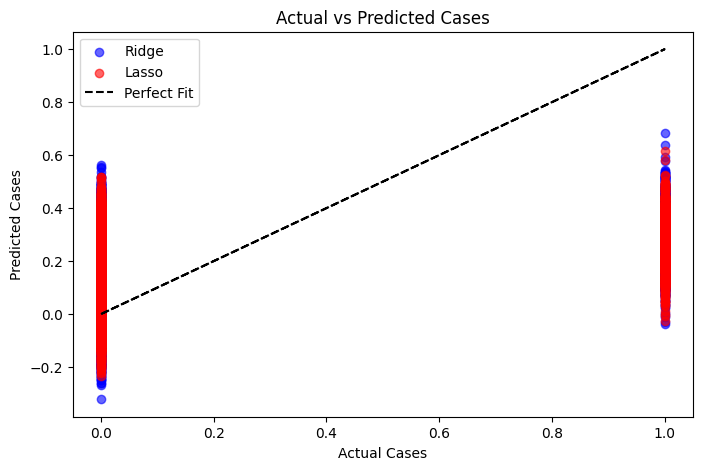

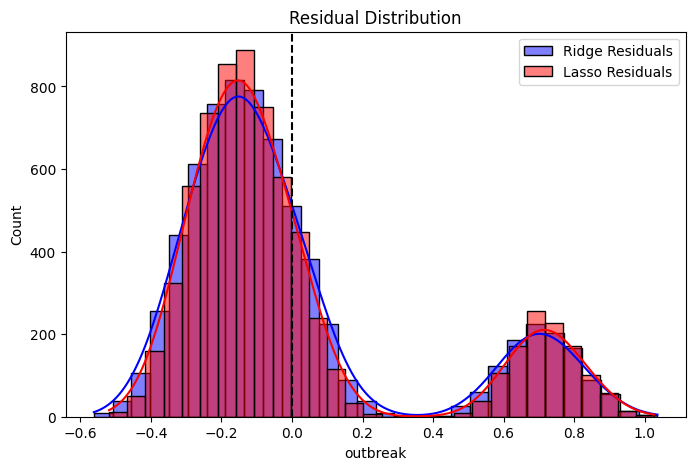

In [ ]:
#linear regression model analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFE

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection using RFE
lin_reg = LinearRegression()
rfe = RFE(lin_reg, n_features_to_select=5)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

# Ridge Regression (L2 Regularization) with Hyperparameter Tuning
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train_selected, y_train)

# Lasso Regression (L1 Regularization) with Hyperparameter Tuning
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='r2')
lasso_grid.fit(X_train_selected, y_train)

# Best models
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_

# Train and Predict with Ridge & Lasso
y_pred_ridge = best_ridge.predict(X_test_selected)
y_pred_lasso = best_lasso.predict(X_test_selected)

# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n🔹 {model_name} Performance:")
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")

evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_ridge, label="Ridge", alpha=0.6, color="blue")
plt.scatter(y_test, y_pred_lasso, label="Lasso", alpha=0.6, color="red")
plt.plot(y_test, y_test, 'k--', label="Perfect Fit")
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Actual vs Predicted Cases")
plt.legend()
plt.show()

# Residual Plot
plt.figure(figsize=(8, 5))
sns.histplot(y_test - y_pred_ridge, bins=30, kde=True, color='blue', label='Ridge Residuals')
sns.histplot(y_test - y_pred_lasso, bins=30, kde=True, color='red', label='Lasso Residuals')
plt.axvline(0, color='black', linestyle='--')
plt.title("Residual Distribution")
plt.legend()
plt.show()

Best Parameters: {'C': 1, 'penalty': 'l1'}
Accuracy: 0.72
Precision: 0.34
Recall: 0.77
F1 Score: 0.47
ROC AUC Score: 0.80


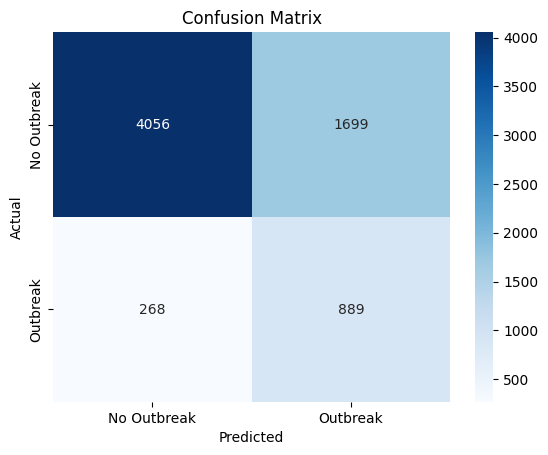

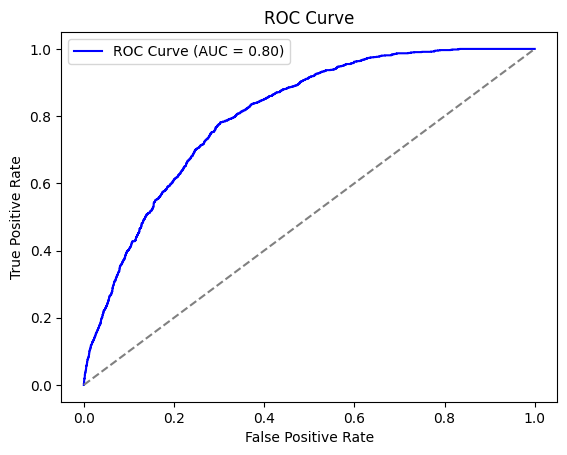


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      5755
           1       0.34      0.77      0.47      1157

    accuracy                           0.72      6912
   macro avg       0.64      0.74      0.64      6912
weighted avg       0.84      0.72      0.75      6912



In [ ]:
#Logistic Regression model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.feature_selection import RFE

# Load dataset
data_path = '/content/processed_climate_disease_dataset.csv'
df = pd.read_csv(data_path)

# Handle missing values
df = df.dropna()

# Create 'total_cases' column and define outbreak threshold
df['total_cases'] = df['malaria_cases'] + df['dengue_cases']
threshold = df['total_cases'].mean() + df['total_cases'].std()
df['outbreak'] = df['total_cases'].apply(lambda x: 1 if x >= threshold else 0)

# Define features (X) and target (y)
climate_columns = ['avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index',
                   'population_density', 'healthcare_budget', 'climate_risk_index']
X = df[climate_columns]
y = df['outbreak']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=500, solver='liblinear')
rfe = RFE(log_reg, n_features_to_select=5)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
grid_search = GridSearchCV(LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced'),
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Train model
best_model.fit(X_train_selected, y_train)

# Predictions
y_pred = best_model.predict(X_test_selected)
y_prob = best_model.predict_proba(X_test_selected)[:, 1]  # Get probabilities for ROC curve

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Outbreak', 'Outbreak'], yticklabels=['No Outbreak', 'Outbreak'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
